[Step 10/200] Immediate Loss: 9.739119054973125 Accumlated Loss: 26.231376632422215
[Step 20/200] Immediate Loss: 8.562010218501092 Accumlated Loss: 9.004294203996658
[Step 30/200] Immediate Loss: 7.791197156310078 Accumlated Loss: 7.894150669425726
[Step 40/200] Immediate Loss: 6.953114957809449 Accumlated Loss: 7.290794907361269
[Step 50/200] Immediate Loss: 6.470913594663144 Accumlated Loss: 7.313350498646497
[Step 60/200] Immediate Loss: 7.192049302458762 Accumlated Loss: 7.292813739836216
[Step 70/200] Immediate Loss: 6.985135128498076 Accumlated Loss: 6.960749062150716
[Step 80/200] Immediate Loss: 7.511157349348067 Accumlated Loss: 6.920082948744298
[Step 90/200] Immediate Loss: 6.9557847833633435 Accumlated Loss: 6.778018771708012
[Step 100/200] Immediate Loss: 6.37305668503046 Accumlated Loss: 6.9952442568838595
[Step 110/200] Immediate Loss: 6.0351421809196495 Accumlated Loss: 6.663454451084136
[Step 120/200] Immediate Loss: 6.581840452551844 Accumlated Loss: 6.54033638453483

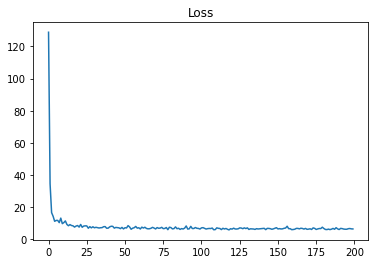

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE

random.seed(123)
torch.manual_seed(123)


# NN used for p(x | y)
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32):
        super().__init__()
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        self.loc_layer = nn.Linear(hidden, 1)
        self.std_layer = nn.Linear(hidden, 1)
        self.softplus = nn.Softplus()
    def forward(self, x):
        if x.dim() == 0:
            x = torch.unsqueeze(x, dim=0)
        hid = F.relu(self.hiddeen_layer(x))
        # return loc, std
        return self.loc_layer(hid), self.softplus(self.std_layer(hid))

# NN used for p(h | x, obs, n)
class simpleHidNN(nn.Module):
    def __init__(self, input_size=3, hidden=32):
        super().__init__()
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        self.loc_layer = nn.Linear(hidden, 1)
        self.std_layer = nn.Linear(hidden, 1)
        self.softplus = nn.Softplus()
    def forward(self, x, obs, n):
        if x.dim() == 0:
            x = torch.unsqueeze(x, dim=0)
        if obs.dim() == 0:
            obs = torch.unsqueeze(obs, dim=0)
        if n.dim() == 0:
            n = torch.unsqueeze(n, dim=0)
        
        input_x = torch.cat([x, obs, n]) # one hot n
        #print(input_x)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        return self.loc_layer(hid), self.softplus(self.std_layer(hid))

class simpleRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, max_l=5, max_t=3):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size + max_l + max_t, hidden_size=hidden_size, nonlinearity='relu',
                          batch_first=True, num_layers=1)
        self.h_0 = nn.Parameter(torch.zeros((1, 1, hidden_size)))
        self.out_loc = nn.Linear(hidden_size, 1)
        self.out_std = nn.Linear(hidden_size, 1)
        self.max_l = max_l # max time steps
        self.max_t = max_t # type of random variables, ex. y1 y2 next_x
        self.softplus = nn.Softplus()
        
    def forward(self, x, obs, l, t):
        """
        x: x0
        obs: R
        l: length
        t: type, y1, y2 or next_x
        """
        length = l * 3
        input_x = x.repeat((int(length), 1))
        input_obs = obs.repeat((int(length), 1))
        input_l = []
        input_t = []
        
        for n in range(int(l)):
            
            for i in range(int(t)):
                input_l.append(n)
                input_t.append(i)
        input_l = F.one_hot(torch.tensor(input_l), self.max_l) 
        input_t = F.one_hot(torch.tensor(input_t), self.max_t) 
        
        input_ = torch.unsqueeze(torch.cat([input_x, input_obs, input_l, input_t], -1), 0)
        
        # the input is [x, obs, onehot(l), onehot(t)]
        rnn_output, _ = self.rnn(input_, self.h_0)
        rnn_output = torch.squeeze(rnn_output, 0)
        out_loc = self.out_loc(F.relu(rnn_output))
        out_std = self.softplus(self.out_std(F.relu(rnn_output)))
        # the first outputs are y_1_1, y_2_1, next_x_1; y_1_2, y_2_2, next_x_2
        return torch.squeeze(out_loc, 1), torch.squeeze(out_std, 1) # shape l * t
        

class Experiment(nn.Module):
    def __init__(self):
        super().__init__()
        self.x_y1_nn = simpleNN()
        self.y1_y2_nn = simpleNN()
        self.y_h_nn = simpleHidNN()
        self.simrnn = simpleRNN()
    
    # assume the model has two latent variables in each time step (note that groundtruth data gen has 3)
    # as we cannot build the perfect model in real life problems
    def model(self, x0, l, obs_R):
        pyro.module("model", self)
        def rec_model(x, n):
            r = torch.tanh(x)
            if n <= 0:
                return r
            else:
                y_1 = pyro.sample("y_1_{}".format(n), dist.Normal(x, 0.5))
             
                y_2 = pyro.sample("y_2_{}".format(n), dist.Normal(y_1, 0.5))
            
                next_x = pyro.sample("next_x_{}".format(n), dist.Normal(y_2, 0.5))
                return rec_model(next_x, n - 1) + r
    
        R = rec_model(x0, l)
    
        pyro.sample("obs_R", dist.Normal(R, 0.1), obs=obs_R)
    
    # guide uses simple and individual NN for each random variable
    def guide1(self, x0, l, obs_R):
        pyro.module("model", self)
        def rec_guide(x, n, obs_R):
            r = torch.tanh(x)
            if n <= 0:
                return r
            else:
                y_1_loc, y_1_std = self.x_y1_nn(x) # maybe input n as well
                y_1 = pyro.sample("y_1_{}".format(n), dist.Normal(y_1_loc, y_1_std))
                
                y_2_loc, y_2_std = self.y1_y2_nn(y_1) # maybe input n as well
                y_2 = pyro.sample("y_2_{}".format(n), dist.Normal(y_2_loc, y_2_std))
                
                h_1_loc, h_1_std = self.y_h_nn(y_2, obs_R, n)
            
                next_x = pyro.sample("next_x_{}".format(n), dist.Normal(h_1_loc, h_1_std))
                return rec_guide(next_x, n - 1, obs_R) + r
    
        rec_guide(x0, l, obs_R)
    
    # guide uses a RNN to estimate distributions of all random variables
    def guide_rnn(self, x0, l, obs_R):
        pyro.module("model", self)
        t = 3
        out_loc, out_std = self.simrnn(x0, obs_R, l, t)
        
        for i in range(int(l)):
            pyro.sample("y_1_{}".format(l - i), dist.Normal(out_loc[i * t], out_std[i * t])) # maybe i here?
            pyro.sample("y_2_{}".format(l - i), dist.Normal(out_loc[i * t + 1], out_std[i * t + 1])) # maybe i here?
            pyro.sample("next_x_{}".format(l - i), dist.Normal(out_loc[i * t + 2], out_std[i * t + 2])) # maybe i here?
        
def generate_data():
    # the actual data generation has three latent variables (y_1, y_2, y_3)
    x0 = torch.tensor(random.random())
    base_std = 0.6
    l = torch.tensor(random.randint(2, 5))
    R = 0
    x = x0
    for i in range(l):
        # standard deviation is decreasing
        std = base_std - i * 0.1
        R += torch.tanh(x)
        
        y_1 = dist.Normal(x, std).sample()
        # add some noise
        noise1 = random.random() / 5
        
        y_2 = dist.Normal(y_1 + noise1, std).sample()
        # add some noise
        
        noise2 = random.random() / 5
        
        y_3 = dist.Normal(y_2 + noise2, std).sample()
        # add some noise
        
        noise3 = random.random() / 5
        
        x = dist.Normal(y_3 + noise3, std).sample()
    return x0.float(), l.float(), R.float()

data = []
num_data = 100
for _ in range(num_data):
    data.append(generate_data())

experiment = Experiment()

adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
guide = experiment.guide_rnn # guide1

svi = SVI(experiment.model, guide, optimizer, loss=Trace_ELBO())

n_steps = 200
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    
    for x0, l, R in data:
        imme_loss += svi.step(x0, l, R) / num_data
        
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {}".format(step, n_steps, imme_loss, loss))
        loss = 0
    
plt.plot(loss_track)
plt.title("Loss")
plt.show()
    

In [2]:
# guide 1
# [Step 10/200] Immediate Loss: 12.392816262543208 Accumlated Loss: 61.896947796434155
# [Step 20/200] Immediate Loss: 12.534820085167881 Accumlated Loss: 13.437604224234818
# [Step 30/200] Immediate Loss: 13.17098607122898 Accumlated Loss: 12.086684818983079
# [Step 40/200] Immediate Loss: 9.71128015607596 Accumlated Loss: 10.062380458921194
# [Step 50/200] Immediate Loss: 9.27166577726603 Accumlated Loss: 9.88789534020424
# [Step 60/200] Immediate Loss: 9.207814403772359 Accumlated Loss: 9.479010441660883
# [Step 70/200] Immediate Loss: 9.252625642120845 Accumlated Loss: 8.992603824317458
# [Step 80/200] Immediate Loss: 10.557749922871592 Accumlated Loss: 9.136339780330657
# [Step 90/200] Immediate Loss: 8.99829298526049 Accumlated Loss: 8.37839320459962
# [Step 100/200] Immediate Loss: 8.004938696920869 Accumlated Loss: 8.489488927960394
# [Step 110/200] Immediate Loss: 7.89229125648737 Accumlated Loss: 8.379414085894823
# [Step 120/200] Immediate Loss: 8.129241148531435 Accumlated Loss: 8.318989044874906
# [Step 130/200] Immediate Loss: 8.806422461569312 Accumlated Loss: 8.2210233835876
# [Step 140/200] Immediate Loss: 8.71400465488434 Accumlated Loss: 7.94223985156417
# [Step 150/200] Immediate Loss: 8.694025435447697 Accumlated Loss: 8.274115405738355
# [Step 160/200] Immediate Loss: 8.1806405210495 Accumlated Loss: 8.218478974461554
# [Step 170/200] Immediate Loss: 8.359754337966441 Accumlated Loss: 8.31694264242053
# [Step 180/200] Immediate Loss: 8.479736644029616 Accumlated Loss: 8.105229493767023
# [Step 190/200] Immediate Loss: 7.703390654921531 Accumlated Loss: 7.726879477888346
# [Step 200/200] Immediate Loss: 8.911449470818045 Accumlated Loss: 8.240651454150676

In [3]:
# guide rnn
# [Step 10/200] Immediate Loss: 9.739119054973125 Accumlated Loss: 26.231376632422215
# [Step 20/200] Immediate Loss: 8.562010218501092 Accumlated Loss: 9.004294203996658
# [Step 30/200] Immediate Loss: 7.791197156310078 Accumlated Loss: 7.894150669425726
# [Step 40/200] Immediate Loss: 6.953114957809449 Accumlated Loss: 7.290794907361269
# [Step 50/200] Immediate Loss: 6.470913594663144 Accumlated Loss: 7.313350498646497
# [Step 60/200] Immediate Loss: 7.192049302458762 Accumlated Loss: 7.292813739836216
# [Step 70/200] Immediate Loss: 6.985135128498076 Accumlated Loss: 6.960749062150716
# [Step 80/200] Immediate Loss: 7.511157349348067 Accumlated Loss: 6.920082948744298
# [Step 90/200] Immediate Loss: 6.9557847833633435 Accumlated Loss: 6.778018771708012
# [Step 100/200] Immediate Loss: 6.37305668503046 Accumlated Loss: 6.9952442568838595
# [Step 110/200] Immediate Loss: 6.0351421809196495 Accumlated Loss: 6.663454451084136
# [Step 120/200] Immediate Loss: 6.581840452551844 Accumlated Loss: 6.540336384534834
# [Step 130/200] Immediate Loss: 6.6818000665307045 Accumlated Loss: 6.712281311541796
# [Step 140/200] Immediate Loss: 6.617580278217792 Accumlated Loss: 6.496850828737021
# [Step 150/200] Immediate Loss: 7.234807396829125 Accumlated Loss: 6.653334019452332
# [Step 160/200] Immediate Loss: 5.998593208491804 Accumlated Loss: 6.719098333090543
# [Step 170/200] Immediate Loss: 6.206380138993265 Accumlated Loss: 6.537967252045871
# [Step 180/200] Immediate Loss: 7.530555124878885 Accumlated Loss: 6.638299534082414
# [Step 190/200] Immediate Loss: 6.48846746265888 Accumlated Loss: 6.428936375379562
# [Step 200/200] Immediate Loss: 6.436221255958077 Accumlated Loss: 6.4630335935950285